## Observations and Insights 

In [27]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
from scipy import stats

plt.style.use('fivethirtyeight')

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
df_mouse_metadata = pd.read_csv(mouse_metadata_path)
df_study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
# Display the data table for preview
df_merged = pd.merge(df_mouse_metadata, df_study_results, on='Mouse ID')
df_merged.rename(columns= {"Age_months": "Age (months)"}, inplace=True)
df_merged

,Mouse ID,Drug Regimen,Sex,Age (months),Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [2]:
df_merged['Mouse ID'].value_counts()

g989    13
a275    10
m650    10
x773    10
c139    10
        ..
n482     1
d133     1
x336     1
o848     1
l872     1
Name: Mouse ID, Length: 249, dtype: int64

In [3]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
duplicate_mice = df_merged[df_merged.duplicated(['Mouse ID', 'Timepoint'])]
duplicate_mice

,Mouse ID,Drug Regimen,Sex,Age (months),Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
909,g989,Propriva,Female,21,26,0,45.000000,0
911,g989,Propriva,Female,21,26,5,47.570392,0
913,g989,Propriva,Female,21,26,10,49.880528,0
915,g989,Propriva,Female,21,26,15,53.442020,0
917,g989,Propriva,Female,21,26,20,54.657650,1


In [4]:
# Optional: Get all the data for the duplicate mouse ID.
df_merged[df_merged['Mouse ID'] == 'g989']

,Mouse ID,Drug Regimen,Sex,Age (months),Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
df_merged = df_merged.set_index('Mouse ID')
mouse = df_merged.drop(index = 'g989')
df_clean = mouse.reset_index()
df_clean

,Mouse ID,Drug Regimen,Sex,Age (months),Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1875,z969,Naftisol,Male,9,30,25,63.145652,2
1876,z969,Naftisol,Male,9,30,30,65.841013,3
1877,z969,Naftisol,Male,9,30,35,69.176246,4
1878,z969,Naftisol,Male,9,30,40,70.314904,4


In [6]:
# Checking the number of mice in the clean DataFrame.
len(df_clean)

1880

## Summary Statistics

In [7]:
df_clean['Drug Regimen'].unique()

array(['Ramicane', 'Capomulin', 'Infubinol', 'Placebo', 'Ceftamin',
       'Stelasyn', 'Zoniferol', 'Ketapril', 'Propriva', 'Naftisol'],
      dtype=object)

In [8]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# This method produces everything in a single groupby function
df_tumor_summary = df_clean.groupby('Drug Regimen').agg({'Tumor Volume (mm3)': ['mean', 'median', 'var', 'std', 'sem']})
df_tumor_summary.rename(columns={'mean': "Mean", 'median': "Median", 'var': "Variance", 'std': "Standard Deviation", 'sem': "SEM"})


Tumor Volume (mm3)                                           \
                           Mean     Median   Variance Standard Deviation   
Drug Regimen                                                               
Capomulin             40.675741  41.557809  24.947764           4.994774   
Ceftamin              52.591172  51.776157  39.290177           6.268188   
Infubinol             52.884795  51.820584  43.128684           6.567243   
Ketapril              55.235638  53.698743  68.553577           8.279709   
Naftisol              54.331565  52.509285  66.173479           8.134708   
Placebo               54.033581  52.288934  61.168083           7.821003   
Propriva              52.320930  50.446266  43.852013           6.622085   
Ramicane              40.216745  40.673236  23.486704           4.846308   
Stelasyn              54.233149  52.431737  59.450562           7.710419   
Zoniferol             53.236507  51.818479  48.533355           6.966589   

                        
                   SEM  
Drug Regimen            
Capomulin     0.329346  
Ceftamin      0.469821  
Infubinol     0.492236  
Ketapril      0.603860  
Naftisol      0.596466  
Placebo       0.581331  
Propriva      0.544332  
Ramicane      0.320955  
Stelasyn      0.573111  
Zoniferol     0.516398

## Bar and Pie Charts

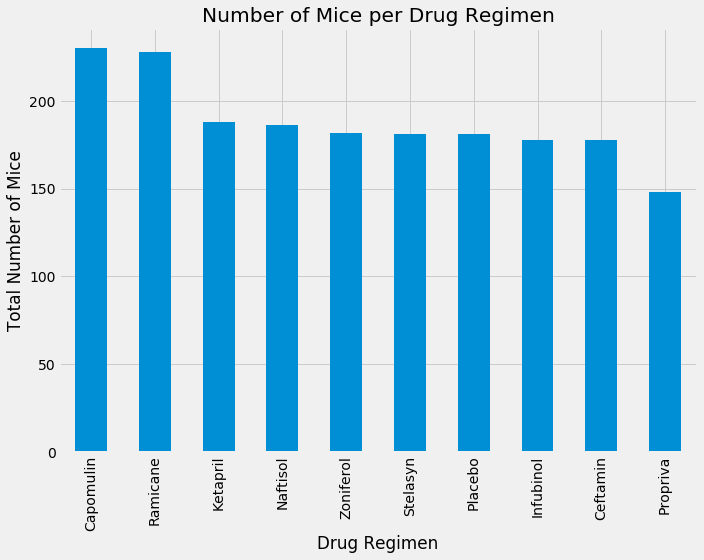

In [9]:
# Generate a bar plot showing the total number of mice for each treatment 
#throughout the course of the study using pandas. 
mice_per_drug = df_clean.groupby(['Drug Regimen']).count()['Mouse ID']

mice_per_drug_sorted = mice_per_drug.sort_values(ascending=False)

mice_bar = mice_per_drug_sorted.plot.bar(figsize=(10,8));
plt.ylabel("Total Number of Mice");
plt.title("Number of Mice per Drug Regimen");
plt.tight_layout()
plt.show()

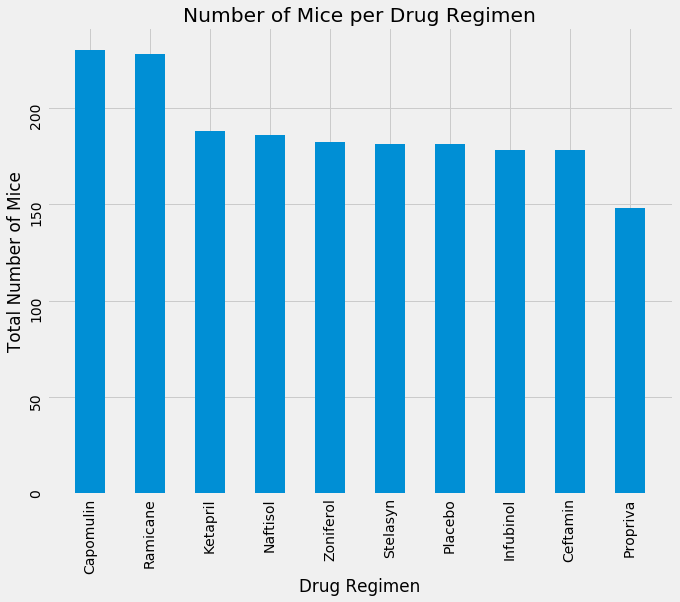

In [10]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pyplot.

# Create an arrays for the x and y axis
x_axis_drugs = np.arange(len(mice_per_drug))
mice = mice_per_drug_sorted

#df_clean.groupby(['Drug Regimen'])['Mouse ID'].count().tolist()

fig1, ax1=plt.subplots(figsize=(10,8))
ax1.bar(x_axis_drugs, mice, align='center', width=.5);
ax1.set(xlabel = "Drug Regimen",
        ylabel = "Total Number of Mice",
       title = "Number of Mice per Drug Regimen",
       xticks = list(x_axis_drugs),
       xticklabels = ['Capomulin','Ramicane','Ketapril','Naftisol','Zoniferol',
        'Stelasyn','Placebo','Infubinol','Ceftamin','Propriva']);
ax1.tick_params(labelrotation=90)
plt.show()

In [11]:
# Create a Dataframe for the gender
df_gender = pd.DataFrame(df_clean['Sex'].value_counts(normalize=True))


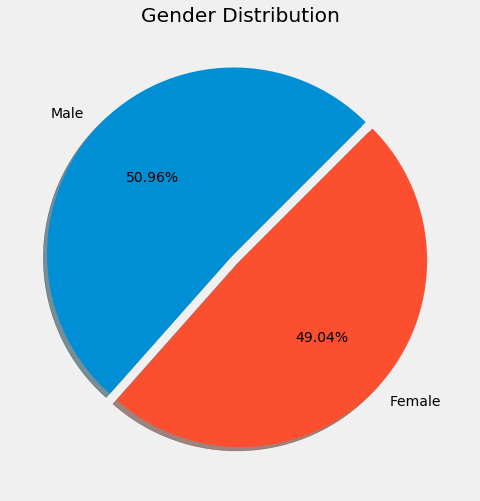

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using pandas

gender_plot = df_gender.plot.pie(y='Sex', figsize=(8,8), autopct='%1.2f%%',
                                explode = (0.05,0), shadow = True,
                                startangle = 45, title="Gender Distribution");
plt.ylabel('')
plt.gca().get_legend().remove()
plt.show()

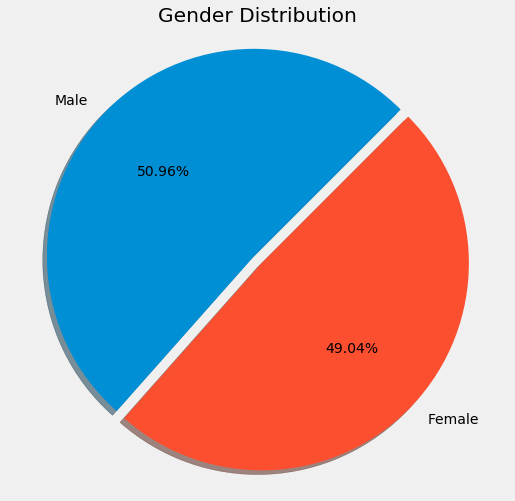

In [13]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
gender_grp = df_clean.groupby('Sex')

gender_size = [958, 922]
pie_labels = "Male", "Female"

fig2, ax2 = plt.subplots(figsize=(8,8))
ax2.pie(gender_size, labels=pie_labels, autopct='%1.2f%%', startangle=45, shadow=True,
       explode=(0.05,0))
ax2.set_title("Gender Distribution")
ax2.axis("equal")
plt.show()

## Quartiles, Outliers and Boxplots

In [14]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin
df_clean_copy = df_clean[['Mouse ID', 'Drug Regimen', 'Timepoint', 
                          'Tumor Volume (mm3)']].copy()
df_clean_sorted = df_clean_copy.sort_values(['Mouse ID', 'Timepoint'], ascending = False)

# Start by getting the last (greatest) timepoint for each mouse
last_timepoint = df_clean_sorted.drop_duplicates(subset='Mouse ID')
last_timepoint = last_timepoint.sort_values('Mouse ID')

In [15]:
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
cap_volume_last = last_timepoint[last_timepoint['Drug Regimen'] == 'Capomulin']
cap_volume_last
cap_vol = cap_volume_last['Tumor Volume (mm3)']

cap_quartiles = cap_vol.quantile([0.25,0.5,0.75])
cap_lowerq = cap_quartiles[0.25]
cap_upperq = cap_quartiles[0.75]
cap_iqr = cap_upperq-cap_lowerq


print(f"The lower quartile of tumors treated with Capomulin: {round(cap_lowerq,2)}")
print(f"The upper quartile of tumors treated with Capomulin: {round(cap_upperq,2)}")
print(f"The interquartile range of tumors treated with Capomulin: {round(cap_iqr,2)}")
print(f"The median of the Capomulin tumors: {round(cap_quartiles[0.5],2)} ")

#Determine outliers using upper and lower bounds
cap_lower_bound = cap_lowerq - (1.5*cap_iqr)
cap_upper_bound = cap_upperq + (1.5*cap_iqr)

print(f"Values below {round(cap_lower_bound,2)} could be outliers.")
print(f"Values above {round(cap_upper_bound,2)} could be outliers.")

The lower quartile of tumors treated with Capomulin: 32.38
The upper quartile of tumors treated with Capomulin: 40.16
The interquartile range of tumors treated with Capomulin: 7.78
The median of the Capomulin tumors: 38.13 
Values below 20.7 could be outliers.
Values above 51.83 could be outliers.


In [16]:
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
ram_volume_last = last_timepoint[last_timepoint['Drug Regimen'] == 'Ramicane']
ram_volume_last
ram_vol = ram_volume_last['Tumor Volume (mm3)']

ram_quartiles = ram_vol.quantile([0.25,0.5,0.75])
ram_lowerq = ram_quartiles[0.25]
ram_upperq = ram_quartiles[0.75]
ram_iqr = ram_upperq-ram_lowerq


print(f"The lower quartile of tumors treated with Ramicane: {round(ram_lowerq,2)}")
print(f"The upper quartile of tumors treated with Ramicane: {round(ram_upperq,2)}")
print(f"The interquartile range of tumors treated with Ramicane: {round(ram_iqr,2)}")
print(f"The median of the Ramicane tumors: {round(ram_quartiles[0.5],2)} ")

#Determine outliers using upper and lower bounds
ram_lower_bound = ram_lowerq - (1.5*ram_iqr)
ram_upper_bound = ram_upperq + (1.5*ram_iqr)

print(f"Values below {round(ram_lower_bound,2)} could be outliers.")
print(f"Values above {round(ram_upper_bound,2)} could be outliers.")

The lower quartile of tumors treated with Ramicane: 31.56
The upper quartile of tumors treated with Ramicane: 40.66
The interquartile range of tumors treated with Ramicane: 9.1
The median of the Ramicane tumors: 36.56 
Values below 17.91 could be outliers.
Values above 54.31 could be outliers.


In [17]:
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
inf_volume_last = last_timepoint[last_timepoint['Drug Regimen'] == 'Infubinol']
inf_volume_last

inf_vol = inf_volume_last['Tumor Volume (mm3)']

inf_quartiles = inf_vol.quantile([0.25,0.5,0.75])
inf_lowerq = inf_quartiles[0.25]
inf_upperq = inf_quartiles[0.75]
inf_iqr = inf_upperq-inf_lowerq


print(f"The lower quartile of tumors treated with Infubinol: {round(inf_lowerq,2)}")
print(f"The upper quartile of tumors treated with Infubinol: {round(inf_upperq,2)}")
print(f"The interquartile range of tumors treated with Infubinol: {round(inf_iqr,2)}")
print(f"The median of the Infubinol tumors: {round(inf_quartiles[0.5],2)} ")

#Determine outliers using upper and lower bounds
inf_lower_bound = inf_lowerq - (1.5*inf_iqr)
inf_upper_bound = inf_upperq + (1.5*inf_iqr)

print(f"Values below {round(inf_lower_bound,2)} could be outliers.")
print(f"Values above {round(inf_upper_bound,2)} could be outliers.")


The lower quartile of tumors treated with Infubinol: 54.05
The upper quartile of tumors treated with Infubinol: 65.53
The interquartile range of tumors treated with Infubinol: 11.48
The median of the Infubinol tumors: 60.17 
Values below 36.83 could be outliers.
Values above 82.74 could be outliers.


In [18]:
# Calculate the IQR and quantitatively determine if there are any potential outliers. 
ceft_volume_last = last_timepoint[last_timepoint['Drug Regimen'] == 'Ceftamin']
ceft_volume_last
ceft_vol = ceft_volume_last['Tumor Volume (mm3)']

ceft_quartiles = ceft_vol.quantile([0.25,0.5,0.75])
ceft_lowerq = ceft_quartiles[0.25]
ceft_upperq = ceft_quartiles[0.75]
ceft_iqr = ceft_upperq-ceft_lowerq


print(f"The lower quartile of tumors treated with Ceftamin: {round(ceft_lowerq,2)}")
print(f"The upper quartile of tumors treated with Ceftamin: {round(ceft_upperq,2)}")
print(f"The interquartile range of tumors treated with Ceftamin: {round(ceft_iqr,2)}")
print(f"The median of the Ceftamin tumors: {round(ceft_quartiles[0.5],2)} ")

#Determine outliers using upper and lower bounds
ceft_lower_bound = ceft_lowerq - (1.5*ceft_iqr)
ceft_upper_bound = ceft_upperq + (1.5*ceft_iqr)

print(f"Values below {round(ceft_lower_bound,2)} could be outliers.")
print(f"Values above {round(ceft_upper_bound,2)} could be outliers.")

The lower quartile of tumors treated with Ceftamin: 48.72
The upper quartile of tumors treated with Ceftamin: 64.3
The interquartile range of tumors treated with Ceftamin: 15.58
The median of the Ceftamin tumors: 59.85 
Values below 25.36 could be outliers.
Values above 87.67 could be outliers.


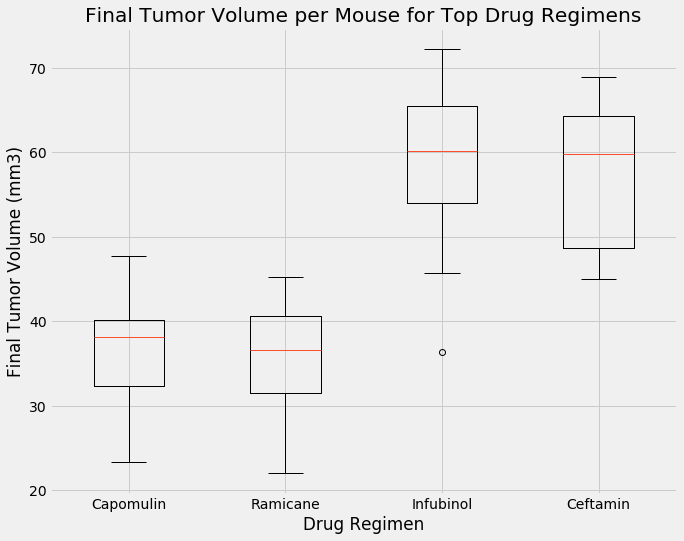

In [19]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest
final_tumor = [cap_vol, ram_vol, inf_vol, ceft_vol]
top_tx = ['Capomulin', 'Ramicane', 'Infubinol','Ceftamin']

fig3, ax3 = plt.subplots(figsize=(10,8))
ax3.boxplot(final_tumor)
ax3.set(xlabel= "Drug Regimen",
        ylabel= "Final Tumor Volume (mm3)",
    title="Final Tumor Volume per Mouse for Top Drug Regimens",
       xticklabels= top_tx);
plt.show()

## Line and Scatter Plots

In [20]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin
cap_mouse = df_clean[df_clean['Drug Regimen'] == 'Capomulin']
mouse_x401 = cap_mouse.loc[cap_mouse['Mouse ID'] == 'x401']
mouse_x401

,Mouse ID,Drug Regimen,Sex,Age (months),Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
20,x401,Capomulin,Female,16,15,0,45.000000,0
21,x401,Capomulin,Female,16,15,5,45.473753,0
22,x401,Capomulin,Female,16,15,10,39.113891,0
23,x401,Capomulin,Female,16,15,15,39.776250,0
24,x401,Capomulin,Female,16,15,20,36.065835,0
25,x401,Capomulin,Female,16,15,25,36.617120,0
26,x401,Capomulin,Female,16,15,30,32.915292,0
27,x401,Capomulin,Female,16,15,35,30.206825,0
28,x401,Capomulin,Female,16,15,40,28.167397,0
29,x401,Capomulin,Female,16,15,45,28.484033,0


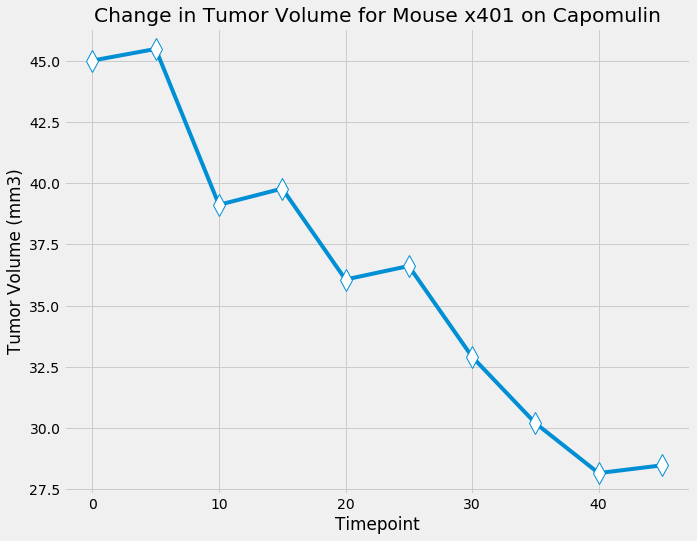

In [21]:
fig4, ax4 = plt.subplots(figsize=(10,8))
ax4.plot(mouse_x401['Timepoint'], mouse_x401['Tumor Volume (mm3)'], 
         marker="d", markerfacecolor='w', markersize=15)
ax4.set(xlabel = "Timepoint",
       ylabel = "Tumor Volume (mm3)",
        title = "Change in Tumor Volume for Mouse x401 on Capomulin");

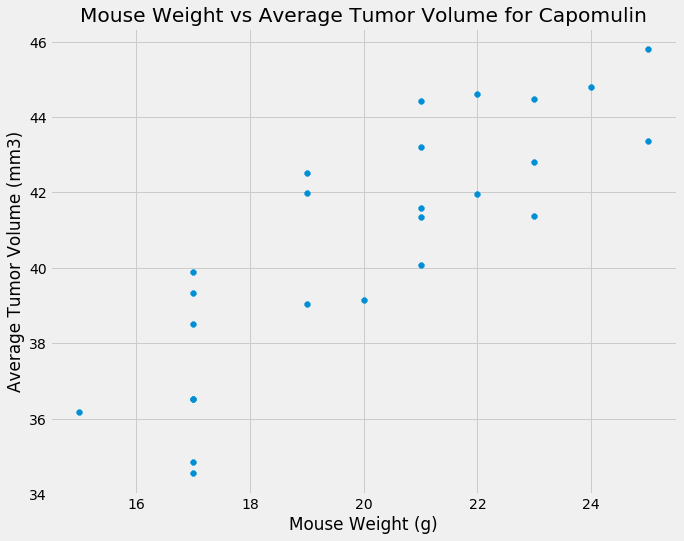

In [25]:
# Generate a scatter plot of mouse weight versus average tumor volume for 
#the Capomulin regimen
cap_scatter = cap_mouse.groupby(['Mouse ID']).mean()

fig5, ax5 = plt.subplots(figsize=(10,8))
ax5.scatter(cap_scatter['Weight (g)'], cap_scatter['Tumor Volume (mm3)'], 
            marker='8')
ax5.set(xlabel="Mouse Weight (g)",
       ylabel="Average Tumor Volume (mm3)",
       title="Mouse Weight vs Average Tumor Volume for Capomulin");

## Correlation and Regression

In [23]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen

correlation = st.pearsonr(cap_scatter['Weight (g)'], cap_scatter['Tumor Volume (mm3)'])
print(f'''The correlation between Mouse Weight and Tumor volume is {round(correlation[0],2)}''')
                                                                 

The correlation between Mouse Weight and Tumor volume is 0.84


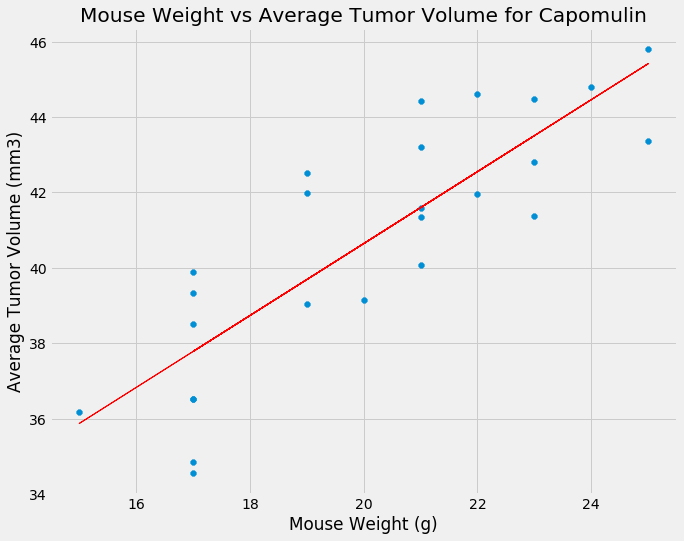

In [34]:
x_values = cap_scatter['Weight (g)']
y_values = cap_scatter['Tumor Volume (mm3)']

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)

regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

fig5, ax5 = plt.subplots(figsize=(10,8))
ax5.scatter(cap_scatter['Weight (g)'], cap_scatter['Tumor Volume (mm3)'], 
            marker='8')
ax5.set(xlabel="Mouse Weight (g)",
       ylabel="Average Tumor Volume (mm3)",
       title="Mouse Weight vs Average Tumor Volume for Capomulin")
ax5.plot(x_values, regress_values, color='r', linewidth=1);